In [1]:
import json

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm

In [2]:
with open( "data.json", "r" ) as raw_data:
    json_normalized = pd.json_normalize(json.load( raw_data ), record_path=["aggregations", "histogram", "buckets"]).to_dict()
    df = pd.DataFrame( data=json_normalized, columns=json_normalized.keys() )


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8371 entries, 0 to 8370
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   key_as_string                             8371 non-null   object 
 1   key                                       8371 non-null   int64  
 2   doc_count                                 8371 non-null   int64  
 3   event_data_occupied_percentage_avg.value  8371 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 327.0+ KB


In [4]:
df["time"] = pd.to_datetime( df["key_as_string"] )
df["day_of_week"] = df["time"].dt.dayofweek.astype("category")
df["month"] = df["time"].dt.month.astype("category")
df["day"] = df["time"].dt.day.astype("category")
df["hour"] = df["time"].dt.hour.astype("category")
df["is_worktime"] = df["hour"].apply( lambda x: True if x >= 7 and x <= 17 else False ).astype("category")
df["avg_occupancy"] = df["event_data_occupied_percentage_avg.value"]

In [5]:
df.head()

key_as_string            key  doc_count  \
0  2023-01-01T00:00:00.000+01:00  1672527600000         92   
1  2023-01-01T01:00:00.000+01:00  1672531200000         92   
2  2023-01-01T02:00:00.000+01:00  1672534800000         92   
3  2023-01-01T03:00:00.000+01:00  1672538400000         92   
4  2023-01-01T04:00:00.000+01:00  1672542000000         92   

   event_data_occupied_percentage_avg.value                      time  \
0                                  0.934783 2023-01-01 00:00:00+01:00   
1                                  1.603804 2023-01-01 01:00:00+01:00   
2                                  2.146196 2023-01-01 02:00:00+01:00   
3                                  1.554348 2023-01-01 03:00:00+01:00   
4                                  1.211304 2023-01-01 04:00:00+01:00   

  day_of_week month day hour is_worktime  avg_occupancy  
0           6     1   1    0       False       0.934783  
1           6     1   1    1       False       1.603804  
2           6     1   1    2       False       2.146196  
3           6     1   1    3       False       1.554348  
4           6     1   1    4       False       1.211304

In [6]:
df_last_month = df.tail( 24 * 30 )

df_last_month.describe()

key   doc_count  event_data_occupied_percentage_avg.value  \
count  7.200000e+02  720.000000                                720.000000   
mean   1.701365e+12   86.686111                                  8.979330   
std    7.487654e+08    8.001483                                 11.675627   
min    1.700071e+12   20.000000                                  0.000000   
25%    1.700718e+12   88.000000                                  1.560028   
50%    1.701365e+12   88.000000                                  2.841356   
75%    1.702012e+12   88.000000                                 13.437244   
max    1.702660e+12   88.000000                                 62.274318   

       avg_occupancy  
count     720.000000  
mean        8.979330  
std        11.675627  
min         0.000000  
25%         1.560028  
50%         2.841356  
75%        13.437244  
max        62.274318

In [26]:
df_last_three_months = df.tail( 7 * 24 * 12 )

df_last_three_months.describe()

key    doc_count  event_data_occupied_percentage_avg.value  \
count  2.016000e+03  2016.000000                               2016.000000   
mean   1.699033e+12    87.500000                                  9.525128   
std    2.095608e+09     4.872875                                 13.526219   
min    1.695406e+12    20.000000                                  0.000000   
25%    1.697219e+12    88.000000                                  1.243097   
50%    1.699033e+12    88.000000                                  2.446875   
75%    1.700846e+12    88.000000                                 13.692415   
max    1.702660e+12    88.000000                                 73.468068   

       avg_occupancy  
count    2016.000000  
mean        9.525128  
std        13.526219  
min         0.000000  
25%         1.243097  
50%         2.446875  
75%        13.692415  
max        73.468068

In [27]:
fig = px.box( x=df["day_of_week"], y=df["avg_occupancy"] )

fig.show()

In [28]:
fig = px.line( x=df_last_three_months["time"], y=df_last_three_months["avg_occupancy"] )

fig.show()

In [29]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_last_three_months['avg_occupancy'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.851821e+00
p-value                        3.574568e-07
#Lags Used                     2.500000e+01
Number of Observations Used    1.990000e+03
Critical Value (1%)           -3.433640e+00
Critical Value (5%)           -2.862993e+00
Critical Value (10%)          -2.567544e+00
dtype: float64


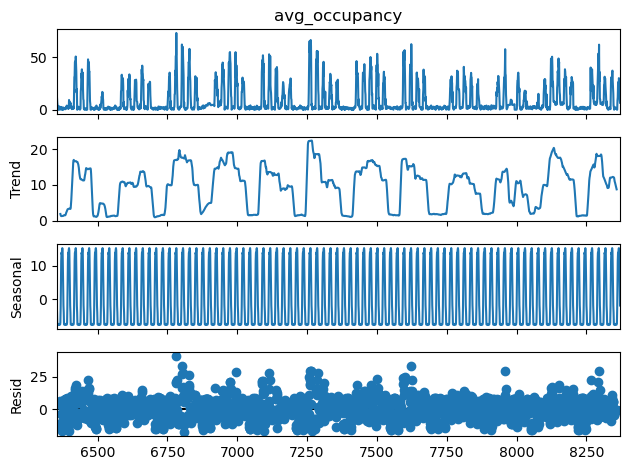

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data_weekly = seasonal_decompose(df_last_three_months["avg_occupancy"], model="additive", period=24*7)
decompose_data_weekly.plot();

In [31]:
df_weekly_res = pd.DataFrame( data=decompose_data_weekly.resid, columns=["resid"] )

In [32]:
fig = px.line( x=df_weekly_res.index, y=df_weekly_res["resid"] )

fig.show()

In [35]:
daily_rolling_mean = df_last_three_months["avg_occupancy"].rolling(window = 24).mean()
weekly_rolling_mean = df_last_three_months["avg_occupancy"].rolling(window = 7*24).mean()

In [36]:
fig = go.Figure()

fig.add_trace( go.Line( x=df_last_three_months.index, y=df_last_three_months["avg_occupancy"], name='data' ))
fig.add_trace( go.Line( x=df_last_three_months.index, y=daily_rolling_mean, name='daily mean' ))
fig.add_trace( go.Line( x=df_last_three_months.index, y=weekly_rolling_mean, name='weekly mean' ))

fig.show()

/home/gregoto4/miniconda3/envs/data_science/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [37]:
df_last_three_months.index = df_last_three_months["time"]

y = df_last_three_months["avg_occupancy"]

X = pd.get_dummies( df_last_three_months[["day_of_week"]], dtype="int" )

X.head()

day_of_week_0  day_of_week_1  day_of_week_2  \
time                                                                     
2023-09-22 19:00:00+01:00              0              0              0   
2023-09-22 20:00:00+01:00              0              0              0   
2023-09-22 21:00:00+01:00              0              0              0   
2023-09-22 22:00:00+01:00              0              0              0   
2023-09-22 23:00:00+01:00              0              0              0   

                           day_of_week_3  day_of_week_4  day_of_week_5  \
time                                                                     
2023-09-22 19:00:00+01:00              0              1              0   
2023-09-22 20:00:00+01:00              0              1              0   
2023-09-22 21:00:00+01:00              0              1              0   
2023-09-22 22:00:00+01:00              0              1              0   
2023-09-22 23:00:00+01:00              0              1              0   

                           day_of_week_6  
time                                      
2023-09-22 19:00:00+01:00              0  
2023-09-22 20:00:00+01:00              0  
2023-09-22 21:00:00+01:00              0  
2023-09-22 22:00:00+01:00              0  
2023-09-22 23:00:00+01:00              0

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

daily_model = SARIMAX(
    y,
    X,
    order=(0, 0, 0),
    seasonal_order=(1, 0, 1, 7*24),
    trend="c",
    freq="H"
)

daily_model_res = daily_model.fit(method="bfgs")

/home/gregoto4/miniconda3/envs/data_science/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



         Current function value: 3.394069
         Iterations: 50
         Function evaluations: 62
         Gradient evaluations: 62


/home/gregoto4/miniconda3/envs/data_science/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



: 

In [ ]:
daily_model_res.aic

14026.328777519322